# Milestone 2

In Milestone 1, our goal was to analyze the influence of ecological scandals on the society. After the review of the assistant, we have thought to slightly change the objective after our first analysis of the dataset. Indeed it was quite difficult to precisely define "ecological scandal" regarding the Gdelt dataset. Moreover, we had to define a precise metric of the "influence" which is quite troublesome. 


With the advice of the TA, we have chosen to enlarge the theme to "Environment" and our goal is now to analyse how media covers environment relate events in the world. We would like to know the principal actors, events, the impact on politics or economy of environment issues from the news point of view.
**As such, we have updated the description and the research questions of the ReadMe.
We have explicited what we would like to do in each question.**


We present here the pipeline we have adopted to answer these questions.

### The data itself
Gdelt files do not contain the name of the columns. We have supposed that the names and the order given in the Gdelt documentation are correct. This is supported by the following file (lien github damien) which we used to parse the columns of the dataset.

Gdelt documentation:

**[GlobalKnowledgeGraph (GKG) V2.1](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf)**

**[GdeltEventDatabase V2.0](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

**[Mention Table](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

As said in the ReadMe, in order to filter the dataset and keep only the environment-related events we keep the items in GKG that contains one of the following tag in their V1THEMES field:
- ```ENV_[*]```: Everything related to environment (from biofuels to overfishing, solar energy, nuclear energy, deforestation...)
- ```SELF_IDENTIFIED_ENVIRON_DISASTER```: Articles where the text explicitly mentions "ecological disaster", "environmental catastrophe", etc
- ```NATURAL_DISASTER```: From floods to coldsnaps, wildfires to tornadoes
- ```MOVEMENT_ENVIRONMENTAL```: Environmental movements

**The [configuration file](cluster/config.py) shows the name and type of the different columns of the dataset as well as the Themes we have kept.**

We then join with the Mention table on the V2DOCUMENTIDENTIFIER mention and then we join the Mention table with GdeltEvent on GLOBALEVENTID to keep the environment-related events.


Moreover, the gdelt dataset contain a lot of null values. We need to keep this in mind when doing computation and fill in or filter this null values.


### Use of the cluster to reduce the dataset size
The entire Gdelt database available in the cluster is of TB. This is an enormous amount of data to deal with. Therefore, the first thing to do is to reduce the amound of data that we are working on. Here we have used the cluster impressive processing power and memory to come up with parquet files that are treatable on our local machines. To this extent, we have to filtered out unnecessary columns (that is columns we will definitely not us in our analysis) but more importantly we need to filtered out information unrelated to environment.

We have written functions in [load_datasets.py](cluster/load_datasets.py) to load the different csv files for gkg, events and mentions and properly parse them with regards to the columns names. Then we drop out unwanted columns. 

For the gkg files, we first keep only records related to environment by regex filtering on the V1THEMES column. Then we tried to transpose the environment themes present in the V1THEMES to onehot columns (by first exploding this semi-column separated string of themes), but we found that the size of the parquet were to large with this solution. So because knowning which particular theme was present in a record was not important for our firsts reasearch questions, we decided to simply dont put this column in the parquets.

Then using these loading functions, we load ([process_data.py](cluster/process_data.py)) all the csv files and agregate them to three parquets: gkg, mentions and events (mentions and events are joined with gkg to filter out non-environment related records).

Size of the parquets:
- GKG: 10.3 GB
- MENTIONS: 3.0 GB
- EVENT: 1.8 GB

### Use of the cluser to get relevant parquets

With these parquets, we can now perform some computations before coming up with small enough parquets to deal with on local machines. 
Below, you can found the code that have generated the different parquets for each part that we will discussed after.

- ***Part 1 Actors:*** [actors.py](cluster/actors.py)
- ***Part 2 Tone:*** [tone.py](cluster/tone.py)
- ***Part 3 Mentions:*** [mentions_counts.py](cluster/mentions_counts.py)

--------

# Analysis of the data

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.getOrCreate()
%matplotlib inline

## Part 1: What are the major actors (person, organisation, country) implied in environment-related events ?

In order to answer this question, we thought it would make sense to count the number of times a person, organisation, and location is mentioned as the first or second actor in an environment-related event. We use the field Actor1TypeCode to discriminate a person (ELI) from an organisation (BUS) from a location (null). ActorType2Code and ActorType3Code are used to identify inside a category, a more precise subtype. For exemple, among the elites we can distinguish a politician from a businessman. 

The end representation we would like to use is a word cloud.

In [4]:
DATA_FOLDER = 'actors'

In [5]:
# Load the data
actors_occurences = spark.read.load(DATA_FOLDER + "/actors_occurences.parquet")

We print the top 20 most cited actors, regardless of their category.

In [6]:
actors_occurences = actors_occurences.sort('Count', ascending=False)
actors_occurences.show(20)

+--------+--------------+---------------+---------------+---------------+
|   Count|    Actor1Name|Actor1Type1Code|Actor1Type2Code|Actor1Type3Code|
+--------+--------------+---------------+---------------+---------------+
|36277291|          null|           null|           null|           null|
|14073597| UNITED STATES|           null|           null|           null|
| 3039767|        POLICE|            COP|           null|           null|
| 2439236|    GOVERNMENT|            GOV|           null|           null|
| 2073960|     PRESIDENT|            GOV|           null|           null|
| 2003752|        SCHOOL|            EDU|           null|           null|
| 1998917|UNITED KINGDOM|           null|           null|           null|
| 1742537|         CHINA|           null|           null|           null|
| 1680969|        RUSSIA|           null|           null|           null|
| 1327082|         SYRIA|           null|           null|           null|
| 1255290|     AUSTRALIA|           nu

We now discriminate a person (ELI) from an organisation (BUS) from a location (null) since it makes no sense to compare a country with a person.

**Elite:** former government officials, celebrities, spokespersons for organizations without further role categorization.

In [7]:
actors_eli_df = actors_occurences.filter(actors_occurences.Actor1Type1Code=="ELI")
actors_eli_df.show(20)

+------+----------------+---------------+---------------+---------------+
| Count|      Actor1Name|Actor1Type1Code|Actor1Type2Code|Actor1Type3Code|
+------+----------------+---------------+---------------+---------------+
|144071|           ACTOR|            ELI|           null|           null|
|102014|         RETIRED|            ELI|           null|           null|
| 86304|          HASSAN|            ELI|           null|           null|
| 54295|          ALBERT|            ELI|           null|           null|
| 43425|      FIRST LADY|            ELI|           null|           null|
| 38557|   UNITED STATES|            ELI|           null|           null|
| 35087|    BILL CLINTON|            ELI|           null|           null|
| 19162|          HASSAN|            ELI|            GOV|           null|
| 18892|    NAWAZ SHARIF|            ELI|            GOV|           null|
| 18614|      SHINZO ABE|            ELI|            GOV|           null|
| 17443|  GEORGE W. BUSH|            E

**Business:** businessmen, companies, and enterprises.

In [8]:
actors_bus_df = actors_occurences.filter(actors_occurences.Actor1Type1Code=="BUS")
actors_bus_df.show(20)

+-------+-------------------+---------------+---------------+---------------+
|  Count|         Actor1Name|Actor1Type1Code|Actor1Type2Code|Actor1Type3Code|
+-------+-------------------+---------------+---------------+---------------+
|1239093|            COMPANY|            BUS|           null|           null|
| 947602|           BUSINESS|            BUS|           null|           null|
| 450499|           INDUSTRY|            BUS|           null|           null|
| 429339|          COMPANIES|            BUS|           null|           null|
| 356868|               BANK|            BUS|           null|           null|
| 214815|           INVESTOR|            BUS|           null|           null|
| 137114|           PRODUCER|            BUS|           null|           null|
| 135265|        CORPORATION|            BUS|           null|           null|
| 133193|            AIRLINE|            BUS|           null|           null|
|  87948|           EMPLOYER|            BUS|           null|   

**Country**

In [9]:
actors_country_df = actors_occurences.filter("Actor1Type1Code is null")
actors_country_df.show(20)

+--------+--------------+---------------+---------------+---------------+
|   Count|    Actor1Name|Actor1Type1Code|Actor1Type2Code|Actor1Type3Code|
+--------+--------------+---------------+---------------+---------------+
|36277291|          null|           null|           null|           null|
|14073597| UNITED STATES|           null|           null|           null|
| 1998917|UNITED KINGDOM|           null|           null|           null|
| 1742537|         CHINA|           null|           null|           null|
| 1680969|        RUSSIA|           null|           null|           null|
| 1327082|         SYRIA|           null|           null|           null|
| 1255290|     AUSTRALIA|           null|           null|           null|
| 1233787|        CANADA|           null|           null|           null|
| 1162937|        ISRAEL|           null|           null|           null|
| 1162476|          IRAN|           null|           null|           null|
| 1136965|        AFRICA|           nu

After having looked at the data, we think that getting the top cited actors with the actor field of the event database is probably not the best way to do. For the business category, we have a lot of results that are irrelevant (for e.g. "company", "bank", "investor"...). We would rather like to have names of actual companies. For the elite category, it's the same thing: "actor", "retired", "United Kingdom" are rather irrelevant. We would prefer to have names of actual persons. 
For this we think it could be better to use the V1LOCATIONS, V1PERSONS and V1ORGANIZATIONS of the GKG database. This is the option we are going to explore next. Otherwise, we will have to manually filter out the names of actors.

## Part 2: What is the evolution in time of the tone of environment-related events in the world ?

Here we analysis the tone of the news of environment-related events in the world. Gdelt has a metric which measure the average “tone” of the document as a whole. This number ranges from -100 (extremely negative) to +100 (extremely positive). Common
values range between -10 and +10, 0 indicates neutral.

We want to grasp the mean tone of these news in the world in a chronological manner to see how these events are perceived during time.

In [10]:
DATA_FOLDER = 'tone'

In [11]:
#Load data 
tones_df = spark.read.parquet(DATA_FOLDER + "/tone_mean_count.parquet")

In [12]:
#Convert to Pandas dataframe
tones = tones_df.toPandas()
tones.head()

,day,month,year,tone_mean
0,18.0,5.0,2015.0,-1.985123
1,3.0,4.0,2015.0,-2.252133
2,8.0,6.0,2015.0,-2.145932
3,24.0,8.0,2016.0,-2.270317
4,25.0,10.0,2017.0,-2.197027


In [13]:
tones['tone_mean'].describe()

count    1011.000000
mean       -2.223917
std         0.188329
min        -3.168995
25%        -2.331496
50%        -2.223420
75%        -2.106588
max        -1.058834
Name: tone_mean, dtype: float64

In [14]:
#Create a datetime column from the year, month, day columns
tones['datetime'] = pd.to_datetime(tones[['year','month','day']])
#Sort the values in chronological order
tones = tones.sort_values(by='datetime') 
tones.head()

,day,month,year,tone_mean,datetime
910,18.0,2.0,2015.0,-2.893717,2015-02-18
566,19.0,2.0,2015.0,-2.197792,2015-02-19
657,20.0,2.0,2015.0,-2.299991,2015-02-20
606,21.0,2.0,2015.0,-2.094941,2015-02-21
57,22.0,2.0,2015.0,-2.017214,2015-02-22


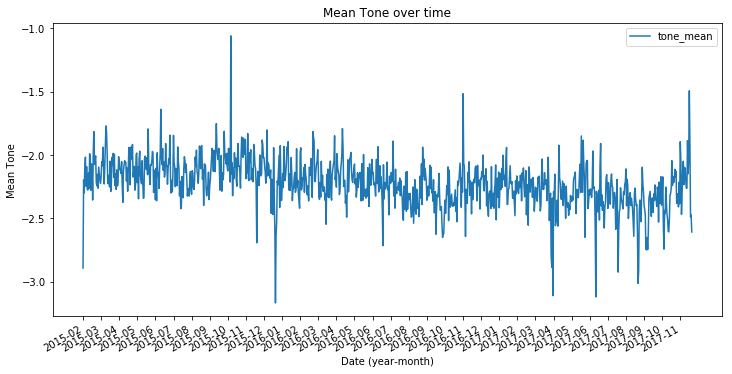

In [15]:
#Plot the mean of the tone against the date
tones.plot('datetime','tone_mean',figsize=(12,6))
# Display a label every month
ticks = tones.datetime.values[0::30]
labels = [str(t).split('-')[0] + "-" + str(t).split('-')[1] for t in ticks]
plt.xticks(ticks, labels)
plt.xlabel("Date (year-month)")
plt.ylabel("Mean Tone")
plt.title("Mean Tone over time")
plt.show()

From this curve and previous analysis, we can see that the mean tone is around -2.2. The negative value is predictable as environment related events are most often related to bad events inducing negative reaction from the public, thus from the news.
What is more important here is the few peaks (such as on 02.2015, 10.2015 or 01.2016) that we can clearly distinguish on the curve. These surely corresponds to particular events which have attracted the attention of the world scene. From the dates, we can further analyse which event correspond to these peaks. To this extent, we have planned to make a word cloud of the person, organisation and country related to these time peak. We can then confirm by looking at wikipedia for instance. This will be an analysis done for the milestone 3.

## Part 3: What is the worldwide evolution in time of the proportion of environment-related mentions ?

In [16]:
DATA_FOLDER = "mentions_counts/"

#### Load countries file

Because GDELT use the FIPS10-4 standard to represent the countries codes, we needed a way to translate them. To this end we use two datasets, one containing all the countries in the world and an another the mapping between ISO and FIPS standards.

In [17]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)

Regions list: ['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


,Country,Region,FIPS,ISO
0,Afghanistan,Asia,AF,AF
278,Åland Islands,Europe,NaN,AX
2,Albania,Europe,AL,AL
3,Algeria,Africa,AG,DZ
4,American Samoa,Oceania,AQ,AS
5,Andorra,Europe,AN,AD
6,Angola,Africa,AO,AO
7,Anguilla,Americas,AV,AI
8,Antarctica,NaN,AY,AQ
9,Antigua and Barbuda,Americas,AC,AG


## Compute ratio of counts of mentions (environment/global)

The file ``mentions_counts_by_state_and_day.csv`` was computed on the cluster by aggregating by state and day all the mentions related to environmental events.
This allowed us to compute the proportion of environment related mentions over all mentions.

In [18]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_day.csv"

In [19]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    counts = counts[["DATE", "STATE", "ISO", "Country", "Region", "GLOBAL_COUNT", "ENV_COUNT", "Ratio"]]
    return counts

In [20]:
def heatmap(counts, key="Country", figsize=(12,12), title="Ratio of mentions (environment/global)"):
    counts = counts[counts.GLOBAL_COUNT>100]
    counts = counts.drop(columns=["ENV_COUNT", "GLOBAL_COUNT"]).dropna()
    pivot = counts.pivot_table(values="Ratio", index=[key], columns=["DATE"], fill_value=0)
    plt.figure(figsize=figsize)
    ax = sns.heatmap(pivot, robust=True)
    ax.set_title(title)

### Place of environment related event in the news, globally

Here we computed this worldwide ratio for each days over the time period covered of the data that are on the cluster

In [21]:
counts = read_csv(counts_file)
counts = counts.groupby(["DATE"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,1.010000e+03,1010.000000,1010.000000
mean,6.957287e+05,173730.531683,0.250822
std,1.743513e+05,54211.969035,0.049963
min,1.753300e+04,6465.000000,0.144273
25%,5.594612e+05,136661.500000,0.218244
50%,7.257745e+05,172871.000000,0.241869
75%,8.137932e+05,203483.000000,0.275431
max,1.547286e+06,460906.000000,0.566061


Text(0, 0.5, 'Ratio')

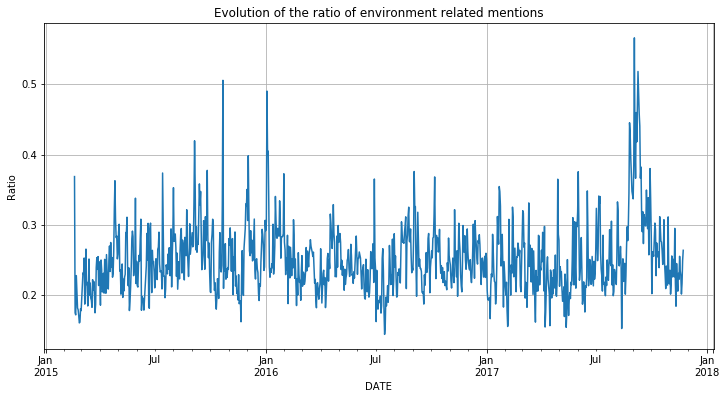

In [22]:
ax = counts.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio")

In [23]:
counts[counts.Ratio>0.47].sort_values("Ratio", ascending=False)

,DATE,GLOBAL_COUNT,ENV_COUNT,Ratio
928,2017-09-03,511475,289526.0,0.566061
934,2017-09-09,426308,220937.0,0.518257
246,2015-10-22,73392,37111.0,0.505655
319,2016-01-03,550698,270036.0,0.490352
935,2017-09-10,403520,197131.0,0.488528


From the descriptive statistics, we can see that the environmental mentions accounts for approximately a quarter of all mentions.

The graph has some surges at specific dates. A rapid check on Wikipedia show that our aggreagation seems to be correct:
- The increase of the ratio in September 2017 correspond to the period during which a hurricane occurred on the east coast of the United States.
- On January 6, 2016, North Korea made a nuclear explosion test, which correspond to the surge occuring on the 3rd

As for the tone, we plan to make a word cloud to identify more precisely the events.

### Place of environment related event in the worldwide news for European countries

Here we computed the same ratio for each days but for each contries in the European region, this would allow make the colorpleth map with the ratio of the coverage of environmental events for each countries.

In [24]:
counts = read_csv(counts_file, countries[countries.Region=="Europe"].FIPS.values)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,45268.000000,45268.000000,45268.000000
mean,2846.426571,656.797539,0.260821
std,7383.020720,1937.022248,0.204617
min,1.000000,1.000000,0.000966
25%,144.000000,25.000000,0.124343
50%,517.000000,96.000000,0.204826
75%,1983.000000,391.000000,0.329670
max,182576.000000,74383.000000,1.000000


In [25]:
europe_counts = counts.groupby(["ISO", "Country"]).sum()
europe_counts = europe_counts.assign(Ratio=europe_counts.ENV_COUNT/europe_counts.GLOBAL_COUNT)
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(20)

,,GLOBAL_COUNT,ENV_COUNT,Ratio
ISO,Country,,,
GB,United Kingdom of Great Britain and Northern Ireland,31422032,5805596.0,0.184762
RU,Russian Federation,22765809,5900408.0,0.259178
FR,France,14499816,3739146.0,0.257875
DE,Germany,10236706,2457812.0,0.240098
IT,Italy,5615193,1498437.0,0.266854
GR,Greece,4975716,1133725.0,0.227852
ES,Spain,3834985,704525.0,0.183710
BE,Belgium,3771457,729045.0,0.193306
IE,Ireland,3769253,595116.0,0.157887


#### Ratio heatmap (by countries and time)

With this heatmap of the ratio, we just tried to look at its "distribution" in time for each countries. We can already see that the data allow to make some finer a analysis at the country level (the white spots corresponding to environmental related events that had a high proportion of mentions for this country).

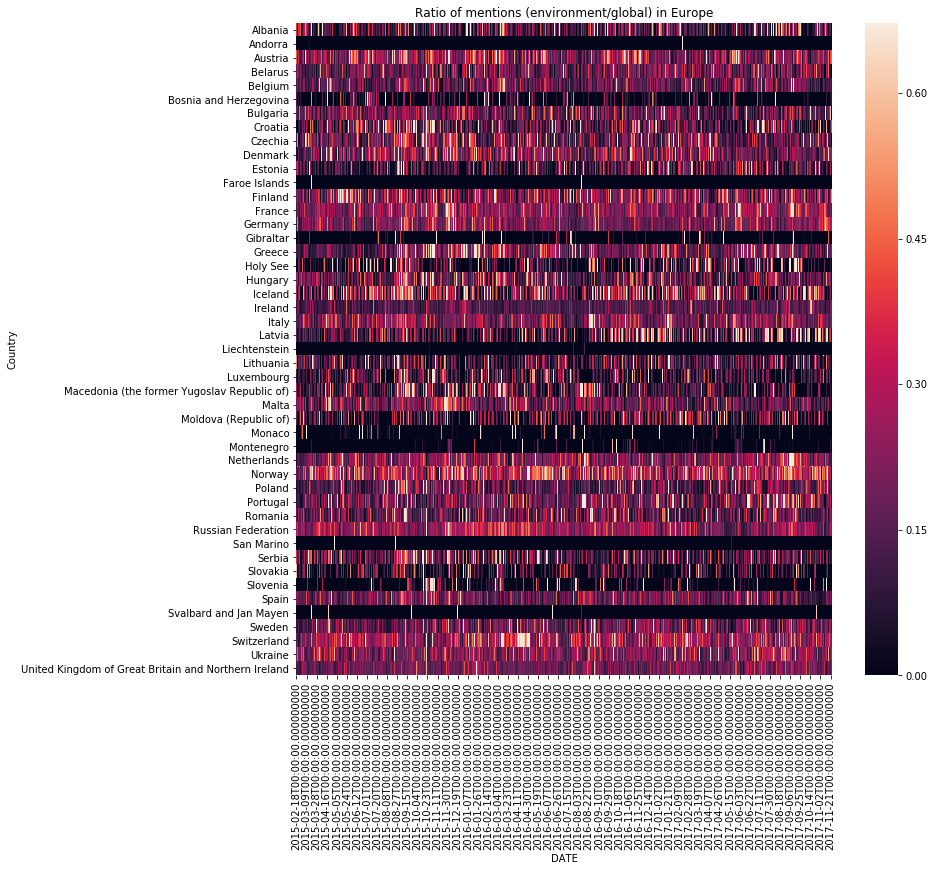

In [26]:
heatmap(counts, key="Country", title="Ratio of mentions (environment/global) in Europe")

## Plan for milestone 3



**Week 1**
- For the "major actor" question, we will make a world cloud with the proper columns as discussed in Part 1 to identify more efficiently the major actors related to environment in the world.
- For the "temporal approach", we will find the events related to the peaks in the tone graph and the mention proportion graph with the use of world clouds (filtered on the datetime of the peak). With these world clouds, we will name the events associated with these peak and confirm these with the use of Wikipedia.
- For the "spatial approach", we will start the use case of Europe by drawing a chloropeth map of European countries with the mention proportion metric. From this, we will see which country is more associated to environment issues.


**Week 2**
- For the "major actor" question, we will try to show the links between the actors in the world with a weighted graph. This will enable to show which kind of actor are more concerned by the environment issues.
- For the "spatial approach", we will compute the evolution in time of the tone by country in order to see which country have a constant tone over time. This will be another metric to see which country is more associated to environment issues. With the use case of Europe, we will visualize the evolution in time of the tone only for European countries.
- Again for the "spatial approch", we will compare the economic status of a country and the news coverage of environment in this country. We can extent this to a comparison with the political unstability.

**Week 3**

In the precedent points, all of our spatial analyses were based on the way the world cover events that happen in a specific country. However, if we have enough time, we think that it would be very intersting to flip the point-of-view and look at how a specific country cover events in the world. To this end, we plan to use an existing dataset that indicates the origin country for each web domain (it is built from the GKG dataset and contain 190K domains), that is we can find from which country the "author" of a mention comes from. We plan to make the same spatial analyses as in week 2.